In [1]:
import tensorflow as tf
import keras
import os,cv2,imghdr
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import time
import pickle
import random

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
IMG_SIZE = 128

In [ ]:
data_dir = "data"

In [ ]:
data = []
label = []

In [ ]:
os.listdir(data_dir)

In [ ]:
#creating data

In [ ]:
for image_class in os.listdir(data_dir):
    class_num = os.listdir(data_dir).index(image_class)
    for image in os.listdir(os.path.join(data_dir,image_class)):
        image_path = os.path.join(data_dir,image_class,image)
        try:
            img = cv2.imread(image_path)
            img_arr = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
            data.append([img_arr,class_num])
        except Exception as e:
            pass
        
      

In [ ]:
random.shuffle(data)

In [ ]:
X = []
y = []

In [ ]:
for arr,label in data:
    X.append(arr)
    y.append(label)

In [ ]:
X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,3)

In [ ]:
y = np.array(y)

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
y.max()

In [ ]:
#saving data
pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close

In [4]:
#loading data

In [5]:
pickle_in = open("X.pickle", "rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle", "rb")
y = pickle.load(pickle_in)

In [6]:
X_train , x_test, Y_train, y_test = train_test_split(X, y, test_size=0.1)

In [7]:
print("testing dataset: {}".format(x_test.shape))
print("remaining dataset: {}".format(X_train.shape))

testing dataset: (398, 128, 128, 3)
remaining dataset: (3582, 128, 128, 3)


In [8]:
x_train , x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.2)

In [9]:
print("validation dataset: {}".format(x_valid.shape))
print("training dataset: {}".format(x_train.shape))

validation dataset: (717, 128, 128, 3)
training dataset: (2865, 128, 128, 3)


In [10]:
x_train = x_train/255.0
x_test = x_test / 255.0
x_valid = x_valid/255.0

In [11]:
y_train = keras.utils.to_categorical(y_train,num_classes=np.max(y) + 1)
y_test = keras.utils.to_categorical(y_test,num_classes=np.max(y) + 1)
y_valid = keras.utils.to_categorical(y_valid,num_classes=np.max(y)+1)

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D

In [13]:
from keras.preprocessing.image import ImageDataGenerator

In [39]:
# optimizing model

In [15]:
NAME = "{}".format(int(time.time()))

In [16]:
#based on tensorboard logs, graphs show that 3 conv layers and 128 layer sizes and 1 dense layer are the best.

model = Sequential()

model.add(Conv2D(128, (3,3), 1, activation='relu',padding="same", input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3,3), 1,padding="same", activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), 1,padding="same", activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(4, activation='softmax'))


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       1

In [18]:
logdir = "log/{}".format(NAME)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)
val_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
            
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
            
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.15,height_shift_range=0.15,horizontal_flip=True)
datagen.fit(x_train)
            
hist = model.fit(datagen.flow(x_train,y_train), epochs=20, validation_data=(x_valid,y_valid), callbacks=[tensorboard_callback,val_callback])


Epoch 1/20
90/90 [==============================] - 17s 120ms/step - loss: 1.2842 - accuracy: 0.4063 - val_loss: 1.1497 - val_accuracy: 0.5286
Epoch 2/20
90/90 [==============================] - 9s 95ms/step - loss: 1.1288 - accuracy: 0.5414 - val_loss: 1.0566 - val_accuracy: 0.5621
Epoch 3/20
90/90 [==============================] - 8s 90ms/step - loss: 1.0290 - accuracy: 0.5745 - val_loss: 0.9895 - val_accuracy: 0.6304
Epoch 4/20
90/90 [==============================] - 8s 90ms/step - loss: 0.9363 - accuracy: 0.6290 - val_loss: 0.8262 - val_accuracy: 0.6932
Epoch 5/20
90/90 [==============================] - 8s 92ms/step - loss: 0.8959 - accuracy: 0.6297 - val_loss: 0.7916 - val_accuracy: 0.6722
Epoch 6/20
90/90 [==============================] - 8s 93ms/step - loss: 0.8453 - accuracy: 0.6576 - val_loss: 0.7781 - val_accuracy: 0.6946
Epoch 7/20
90/90 [==============================] - 8s 92ms/step - loss: 0.8068 - accuracy: 0.6782 - val_loss: 0.7918 - val_accuracy: 0.6722
Epoch 8/20


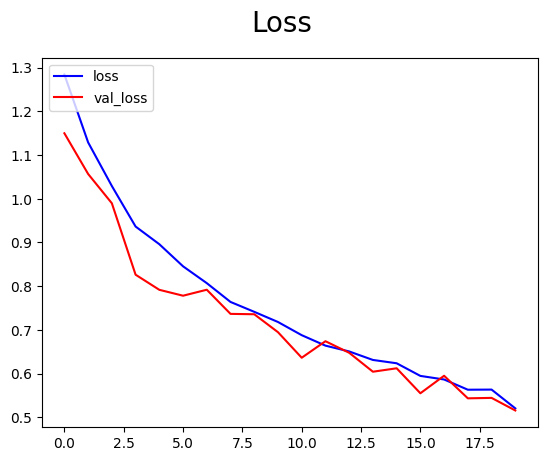

In [19]:
fig = plt.figure()
plt.plot(hist.history["loss"], color="blue", label="loss")
plt.plot(hist.history["val_loss"], color="red", label="val_loss")
fig.suptitle("Loss", fontsize=20)
plt.legend(loc="upper left")
plt.show()

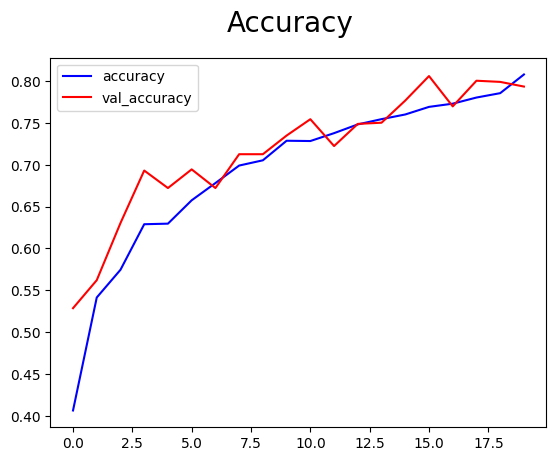

In [20]:
fig = plt.figure()
plt.plot(hist.history["accuracy"], color="blue", label="accuracy")
plt.plot(hist.history["val_accuracy"], color="red", label="val_accuracy")
fig.suptitle("Accuracy", fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [21]:
_,acc = model.evaluate(x_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

13/13 [==============================] - 1s 57ms/step - loss: 0.4388 - accuracy: 0.8342
Accuracy =  83.41708779335022 %


In [ ]:
#testing model

1/1 [==============================] - 0s 21ms/step
Original class is: voleyball
Predicted class is: voleyball


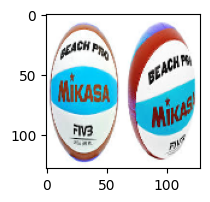

In [38]:
test_img_number = random.randint(0, len(x_test))
test_img = x_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
ground_truth= np.argmax(y_test[test_img_number], axis=None)
prediction = model.predict(test_img_input)

predicted_class = np.argmax(prediction, axis=None)

plt.figure(figsize=(2, 2))
plt.imshow(test_img)

classes = ["american_football", "basketball", "football", "voleyball"]
original_label=classes[ground_truth]
prediction_label=classes[predicted_class]

print("Original class is:", original_label)
print("Predicted class is:", prediction_label);